In [199]:
# Basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix

Read train.csv

In [85]:
df_train = pd.read_csv("./Titanic---ML-from-Disaster/train.csv", delimiter=',')

In [17]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train.shape

(891, 12)

In [86]:
%%time
print(f"Antes: {df_train.shape[0]}")
df_train = df_train.drop_duplicates(keep='first')
print(f"Ahora: {df_train.shape[0]}")

Antes: 891
Ahora: 891
Wall time: 7.01 ms


In [87]:
%%time
print(f"Then: {df_train.shape[0]}")
df_train = df_train.drop_duplicates(subset=['PassengerId'], keep='first')
print(f"Now: {df_train.shape[0]}")

Antes: 891
Ahora: 891
Wall time: 3.98 ms


In [21]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [89]:
%%time
print(f"Then: {df_train.shape()}")
df_train.dropna(subset=['Embarked'], inplace=True)
# Another option: train['Age'].fillna(train['Age'].median(),inplace = True)
print(f"Now: {df_train.shape()}")

In [90]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,889.0,446.000000,256.998173,1.00,224.0000,446.0000,668.0,891.0000
Survived,889.0,0.382452,0.486260,0.00,0.0000,0.0000,1.0,1.0000
Pclass,889.0,2.311586,0.834700,1.00,2.0000,3.0000,3.0,3.0000
Age,712.0,29.642093,14.492933,0.42,20.0000,28.0000,38.0,80.0000
SibSp,889.0,0.524184,1.103705,0.00,0.0000,0.0000,1.0,8.0000
Parch,889.0,0.382452,0.806761,0.00,0.0000,0.0000,0.0,6.0000
Fare,889.0,32.096681,49.697504,0.00,7.8958,14.4542,31.0,512.3292


In [91]:
# Completar
df_train.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
df_train.drop('Cabin', axis=1, inplace=True)
df_train[df_train.Age < 1 ] = int(df_train.Age.mean())

In [92]:
q75,q25=df_train['Age'].quantile([0.75,0.25])
iqr=q75-q25
min_age=0#q25-(iqr*1.5) # deberia ser cero...
max_age=q75+(iqr*1.5)
df_train = df_train[(df_train['Age']>min_age)&(df_train['Age']<max_age)]

# train['Age'].fillna(train['Age'].median(),inplace = True)

In [93]:
categorical_columns = list(df_train \
     .select_dtypes(['object']).columns)
categorical_columns

['Sex', 'Embarked']

In [94]:
df_train[categorical_columns].head()

,Sex,Embarked
0,male,S
1,female,C
2,female,S
3,female,S
4,male,S


In [95]:
df_train.Sex.value_counts()

male      435
female    257
29          7
Name: Sex, dtype: int64

In [96]:
df_train = df_train[df_train['Sex']!=29]

In [97]:
df_train.Embarked.value_counts()

S    542
C    124
Q     26
Name: Embarked, dtype: int64

In [98]:
def applyOHE(df, categorical_features_sin_target):
    for i in categorical_features_sin_target:

        # instance
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

        # train
        enc.fit(df[i].values.reshape(-1,1))

        # transform
        encoded = enc.transform(df[i].values.reshape(-1, 1))

        # getter
        encoded_columns = enc.get_feature_names_out([i])
        encoded_df = pd.DataFrame(data=encoded, columns= encoded_columns)
        df = pd.concat([df, encoded_df], axis=1, join='inner').drop(i, 1)
    
    return enc, df

ohe_sex, df_train = applyOHE(df_train, ['Sex'])

ohe_embarked, df_train = applyOHE(df_train, ['Embarked'])

df_train.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_16880\1890467185.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = pd.concat([df, encoded_df], axis=1, join='inner').drop(i, 1)
C:\Users\Asus\AppData\Local\Temp\ipykernel_16880\1890467185.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = pd.concat([df, encoded_df], axis=1, join='inner').drop(i, 1)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [124]:
df_train.Parch.value_counts()

0    303
1     59
2     43
5      2
3      2
4      2
Name: Parch, dtype: int64

# EDA (Exploratory Data Analysis)

Target distribution

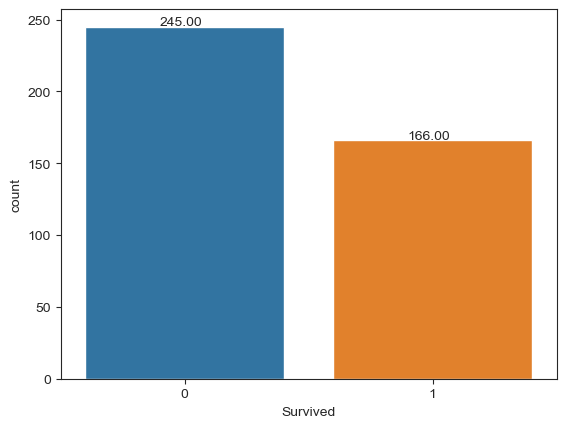

In [195]:
sns.set_style('ticks')
su = sns.countplot(x='Survived', data = df_train)

for p in su.patches:
    su.annotate('{:.2f}'.format(p.get_height()),(p.get_x()+0.3,p.get_height()+1))

In [101]:
df_train.Survived.value_counts()

0    245
1    166
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Pclass', ylabel='count'>

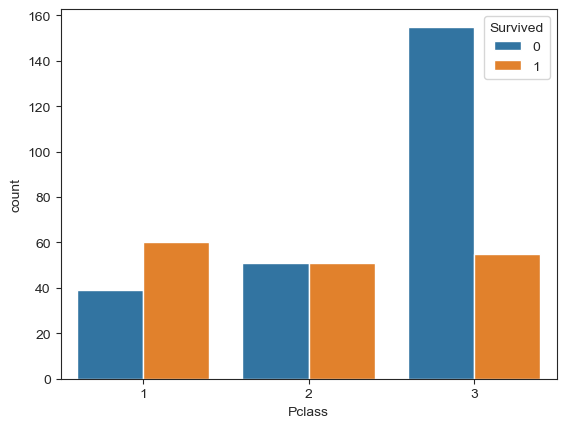

In [196]:
sns.countplot(x='Pclass',hue = 'Survived',data = df_train)

In [197]:
sns.countplot(x = 'Sex', hue = 'Survived', data = df_train)

ValueError: Could not interpret input 'Sex'

## Correlation

<AxesSubplot:>

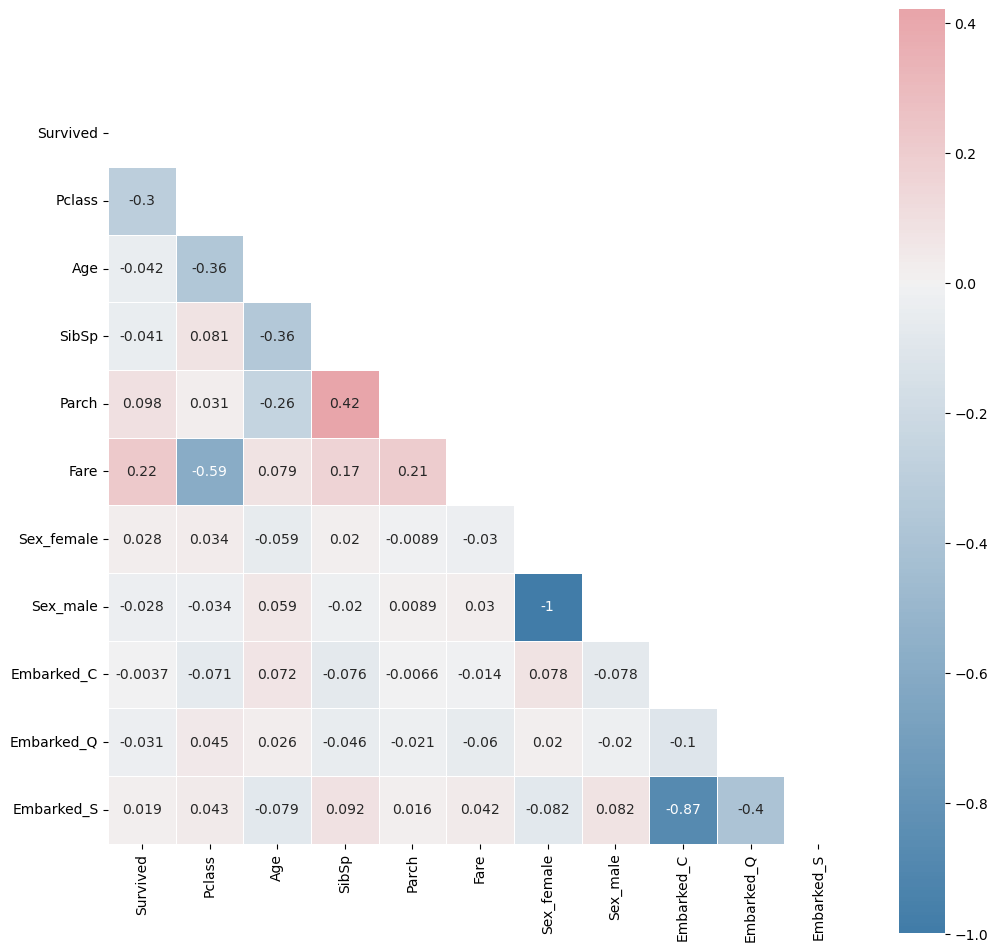

In [102]:
# COMPLETAR
mask = np.triu(np.ones_like(df_train.corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_train.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=True)

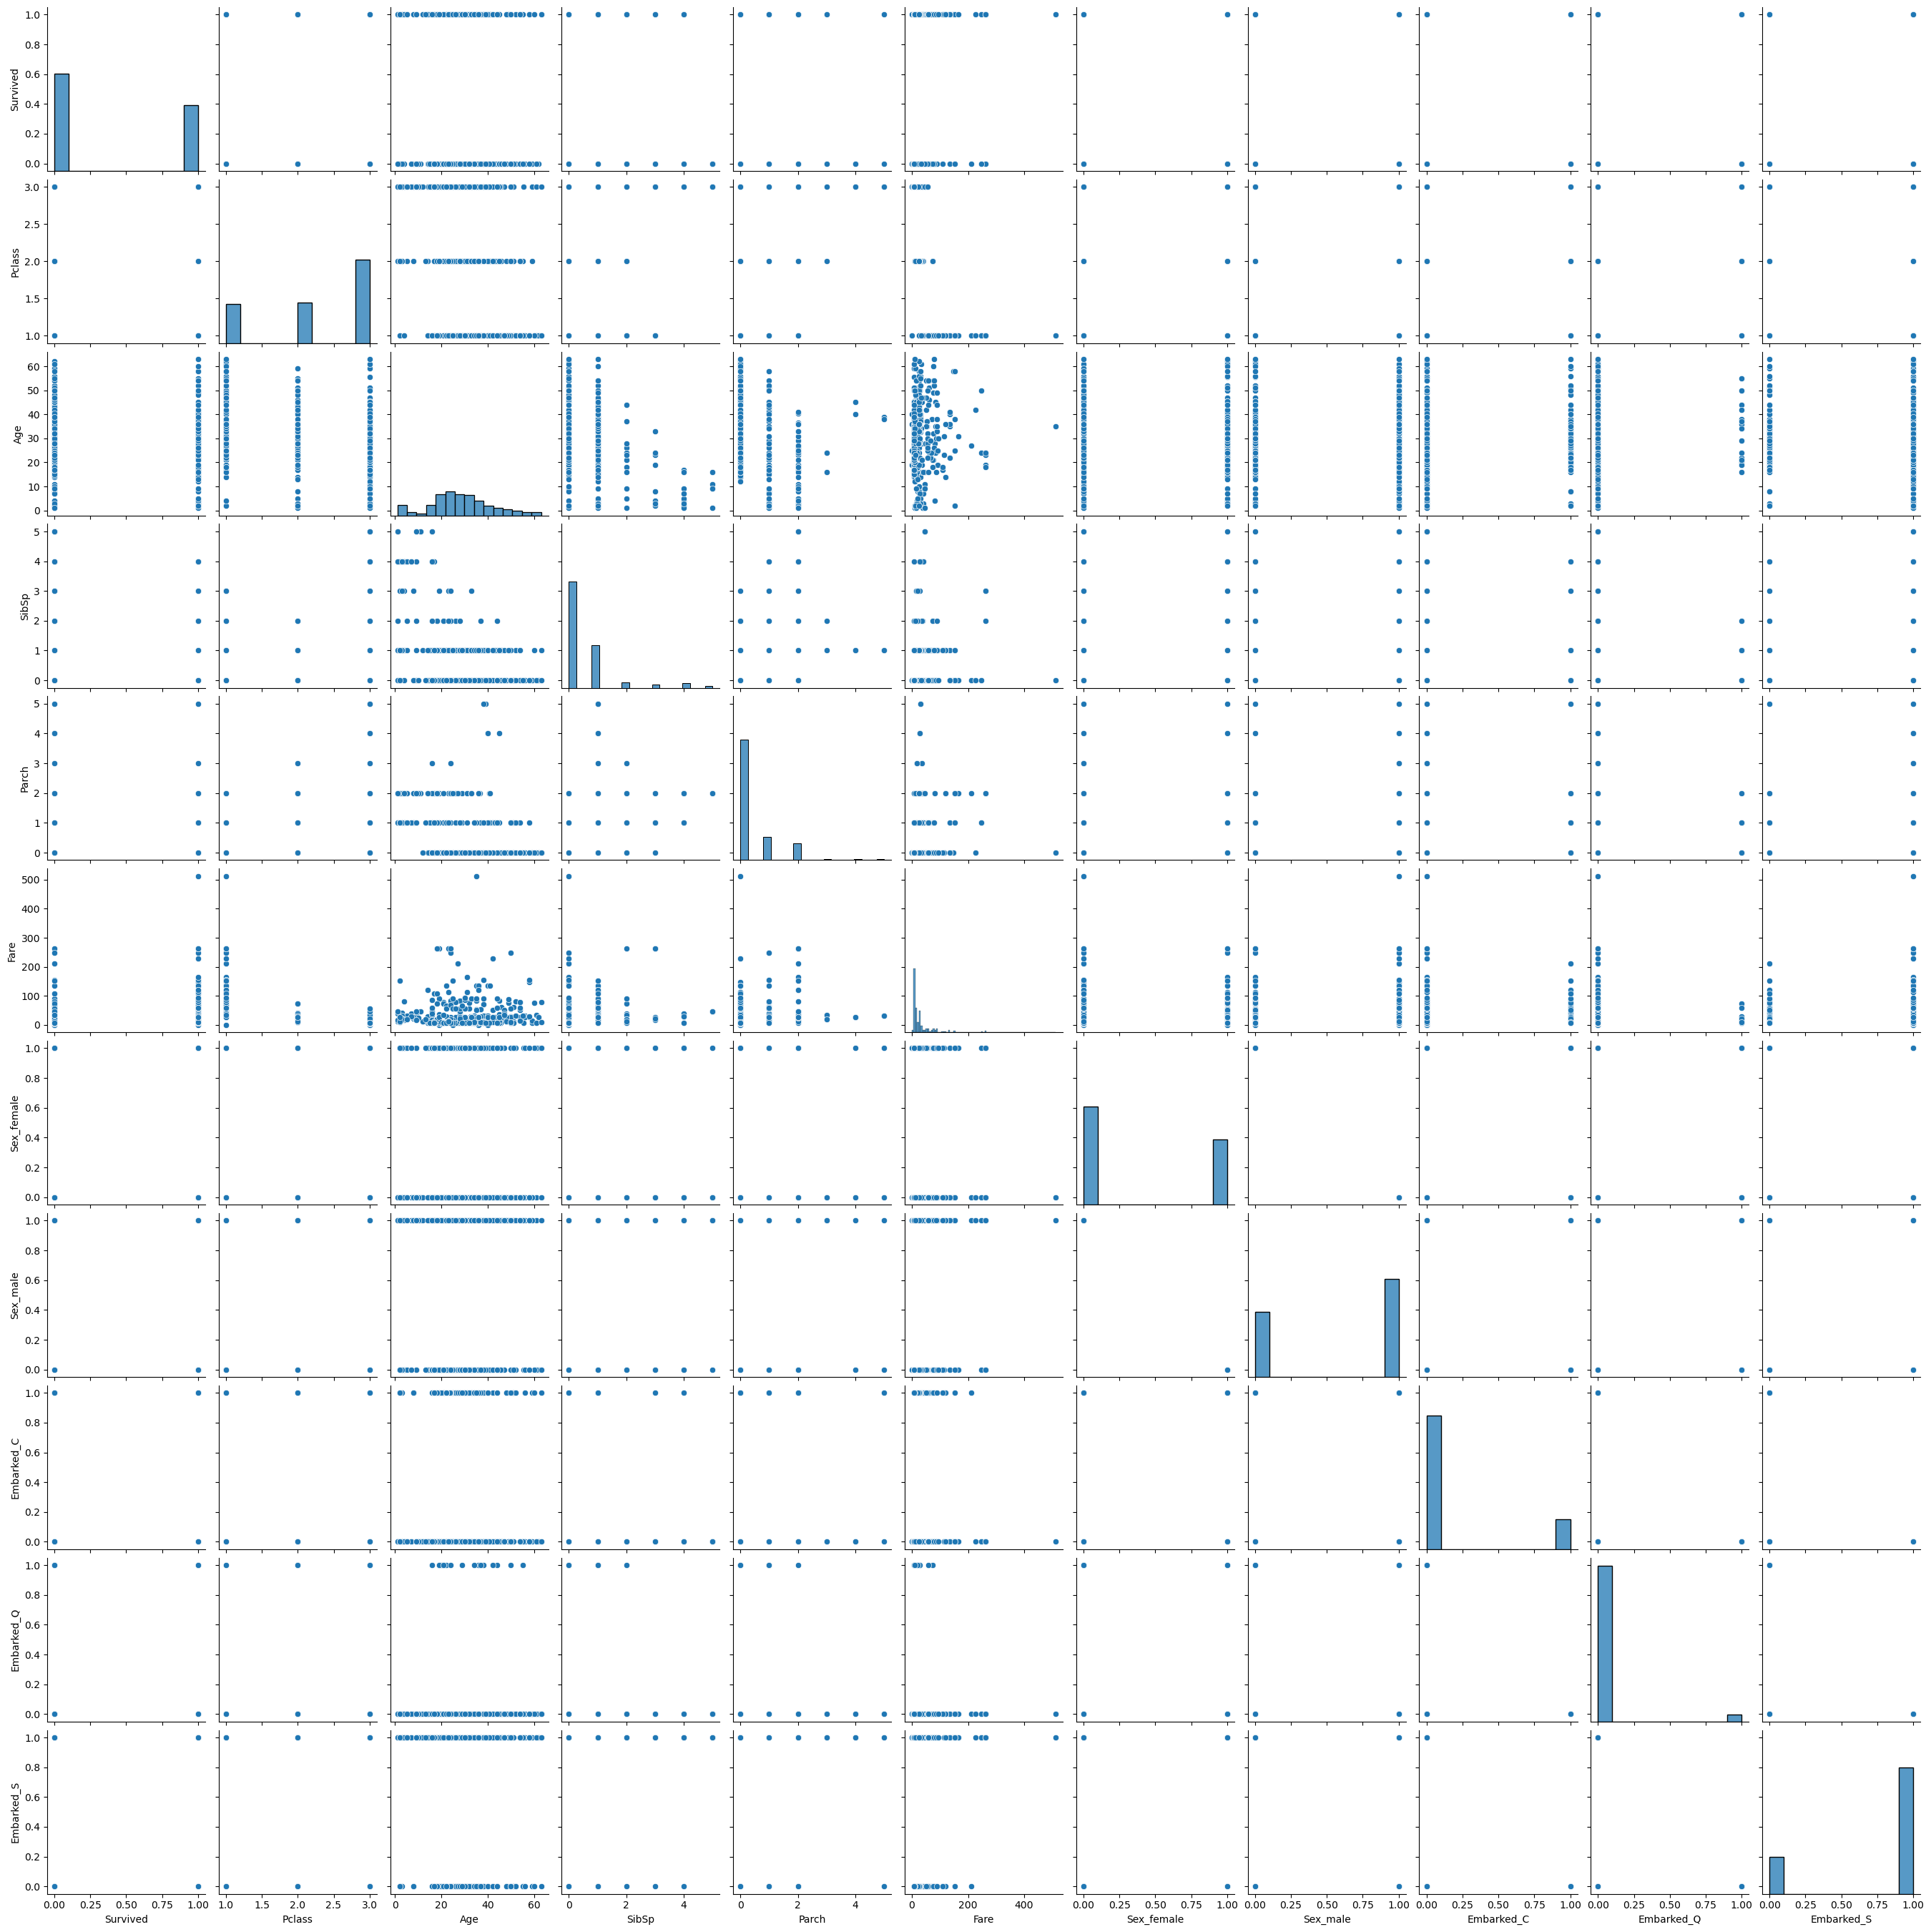

In [176]:
sns.pairplot(df_train)

# Model

In [207]:
X = df_train.drop(['Survived'], axis=1).copy()
# X = X[['Pclass','Sex_male','Sex_female','SibSp','Parch']]
X.head()

,Pclass,Sex_male,Sex_female,SibSp,Parch
0,3,1.0,0.0,1,0
1,1,0.0,1.0,1,0
2,3,0.0,1.0,0,0
3,1,0.0,1.0,1,0
4,3,1.0,0.0,0,0


In [107]:
y = df_train['Survived'].copy()

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [209]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(328, 5)
(83, 5)
(328,)
(83,)


## Decision Tree Classifier Model

In [210]:
# train the model
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [211]:
# Predictions on train
y_train_pred_tree = tree.predict(X_train)
# Predictions on test
y_test_pred_tree = tree.predict(X_test)

In [212]:
# Accuracy
train_acc = accuracy_score(y_train, y_train_pred_tree)
test_acc = accuracy_score(y_test, y_test_pred_tree)

print('Accuracy on train:', train_acc)
print('Accuracy on test:',test_acc)

Accuracy on train: 0.6920731707317073
Accuracy on test: 0.6506024096385542


In [213]:
print(classification_report(y_test, y_test_pred_tree))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73        49
           1       0.60      0.44      0.51        34

    accuracy                           0.65        83
   macro avg       0.64      0.62      0.62        83
weighted avg       0.64      0.65      0.64        83



In [154]:
confusion_matrix(y_test, y_test_pred)

array([[46,  3],
       [26,  8]], dtype=int64)

C:\Users\Asus\anaconda3-2022\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


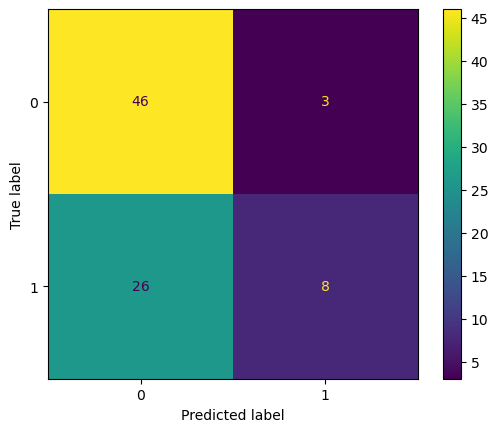

In [155]:
plot_confusion_matrix(tree, X_test, y_test)
plt.show()

## KNN Model

In [165]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [166]:
# Predictions on train
y_train_pred_knn = tree.predict(X_train)
# Predictions on test
y_test_pred_knn = tree.predict(X_test)

In [167]:
train_acc_knn = accuracy_score(y_train, y_train_pred_knn)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)

print('Accuracy on train:', train_acc_knn)
print('Accuracy on test:',test_acc_knn)

Accuracy on train: 0.7042682926829268
Accuracy on test: 0.6506024096385542


In [170]:
print(classification_report(y_test, y_test_pred_knn))

              precision    recall  f1-score   support

           0       0.64      0.94      0.76        49
           1       0.73      0.24      0.36        34

    accuracy                           0.65        83
   macro avg       0.68      0.59      0.56        83
weighted avg       0.68      0.65      0.59        83



In [159]:
confusion_matrix(y_test, y_test_pred)

array([[46,  3],
       [26,  8]], dtype=int64)

C:\Users\Asus\anaconda3-2022\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


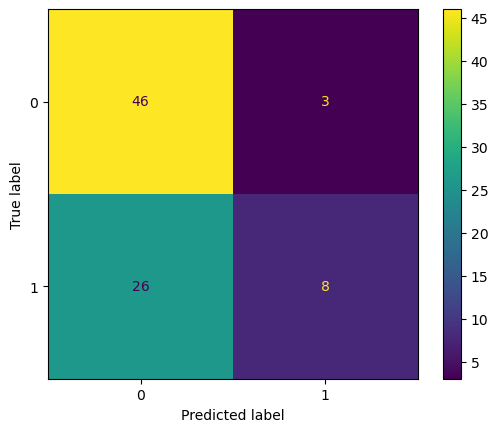

In [160]:
plot_confusion_matrix(tree, X_test, y_test)
plt.show()

Vamos a volver a entrenar el modelo pasando una lista para iterar con diferentes valores de K. Luego evaluaremos accuracy para cada uno de los valores.

In [163]:
#defino las listas de los accuracy scores
lista_accuracy_train = []
lista_accuracy_test = []

#defino lista para el nro de vecinos
vecinos = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

for k in vecinos:

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    #obtengo predicciones
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    
    #accuracy test
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    #guardo los valores de accuracy
    lista_accuracy_train.append(train_acc)
    lista_accuracy_test.append(test_acc)

C:\Users\Asus\anaconda3-2022\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Asus\anaconda3-2022\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set 

C:\Users\Asus\anaconda3-2022\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Asus\anaconda3-2022\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set 

Graficamos la performance del modelo

Text(0.5, 1.0, 'KNN Performance')

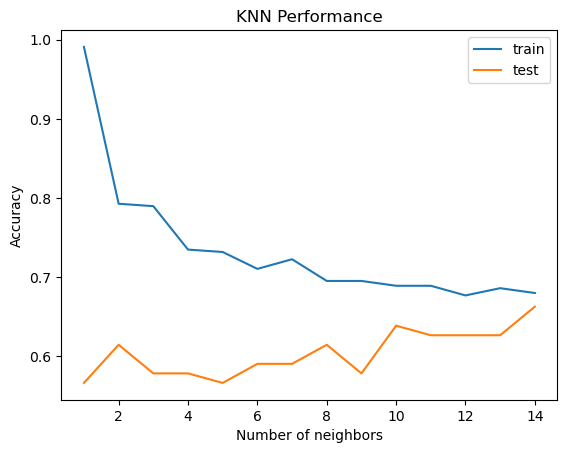

In [164]:
plt.plot(vecinos, lista_accuracy_train, label = 'train')
plt.plot(vecinos, lista_accuracy_test, label = 'test')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.title("KNN Performance")

## SVC

In [178]:
sx_X = StandardScaler()
X_train = sx_X.fit_transform(X_train)
X_test = sx_X.transform(X_test)

In [181]:
classifier = SVC(C=1, kernel='linear', random_state=0)
classifier.fit(X_train, y_train)


SVC(C=1, kernel='linear', random_state=0)

In [183]:
# Predictions on train
y_train_pred_svc = classifier.predict(X_train)
# Predictions on test
y_test_pred_svc = classifier.predict(X_test)

In [184]:
train_acc_svc = accuracy_score(y_train, y_train_pred_svc)
test_acc_svc = accuracy_score(y_test, y_test_pred_svc)

print('Accuracy on train:', train_acc_svc)
print('Accuracy on test:',test_acc_svc)

Accuracy on train: 0.6859756097560976
Accuracy on test: 0.6867469879518072


# GridSearch

In [186]:
#COMPLETAR
parameters = {
    "max_depth":[2,3,4,5,6],
    "min_samples_split":[2,3,4,5,6],
    "min_samples_leaf":[1,2,3,4]
}

parameters_knn = {
    "n_neighbors":[2,3,4,5,6,7,8,9,10]
}

parameters_svc = {
    "C":[0.01, 0.1, 0.2, 0.5, 0.7, 0.9, 1],
    "kernel":["linear", "poly", "rbf", "sigmoid"]
}

In [130]:
#COMPLETAR
gridsearch = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6]})

In [143]:
gridsearch_knn = GridSearchCV(KNeighborsClassifier(), parameters_knn, n_jobs=-1)
gridsearch_knn.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [187]:
gridsearch_svc = GridSearchCV(SVC(), parameters_svc, n_jobs=-1)
gridsearch_svc.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.2, 0.5, 0.7, 0.9, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [133]:
gridsearch.best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [144]:
gridsearch_knn.best_params_

{'n_neighbors': 4}

In [188]:
gridsearch_svc.best_params_

{'C': 1, 'kernel': 'rbf'}

In [135]:
y_train_pred = gridsearch.predict(X_train)
y_test_pred = gridsearch.predict(X_test)

In [136]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Accuracy on train:', train_acc)
print('Accuracy on test:',test_acc)

Accuracy on train: 0.7835365853658537
Accuracy on test: 0.5421686746987951


In [189]:
y_train_pred = gridsearch_svc.predict(X_train)
y_test_pred = gridsearch_svc.predict(X_test)

In [190]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print('Accuracy on train:', train_acc)
print('Accuracy on test:',test_acc)

Accuracy on train: 0.7408536585365854
Accuracy on test: 0.7108433734939759
